# Sentiment Analysis of Movie Reviews pt.4 -- BERT


 This study of sentimental analysis of IMDb movie reviews, I used classic supervised learning methods. In this part, I will use transfer learning with the model BERT.

## Transfer Learning
Unlike the models trained by myself part 1–3, transfer learning is a method of using already existing pre-trained models to deal with a specific task. The model for this time, BERT, is a state-of-the-art deep learning model for multiple purposes in Natural Language Understanding field invented by Google researchers. By fine-tuning BERT to this dataset of IMDb movie reviews, I do not need to train my own model, but to use the transferred model for this specific task of predicting the sentiments for movie reviews. To explain it in a figurative way, training a supervised learning model is like building a car yourself; fine-tuning a transfer learning model is like car-tuning, buying a car and modifying it.

## Pytorch and CUDA
After reading all the data, I will use Pytorch, a package for deep learning. CUDA in Pytorch is a toolkit that allows using GPU for parallel computing (but actually I do not have GPU on my local computer so I will still use CPU). To explain it in a figurative way. When you deliver something, using CPU is like driving a fast car to move a small amount of cargo; using GPU is like driving multiple pick-up trucks simultaneously to move a large amount of cargo. Because in deep learning, the calculation is a large amount of matrix multiplication, using GPU will speed up the process.

In [11]:
import torch
# read all movie reviews sentiments
labels = []
reviews = []
with open('imdb_labelled.txt', encoding='utf-8') as file:
    for line in file:
        # get sentence and label
        sentence, label = line.strip('\n').split('\t')
        reviews.append(sentence)
        labels.append(int(label))

print(f'total number of samples: {len(labels)}')

# use cuda to run this program on GPU.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

total number of samples: 1000
No GPU available, using the CPU instead.


## Tokenization
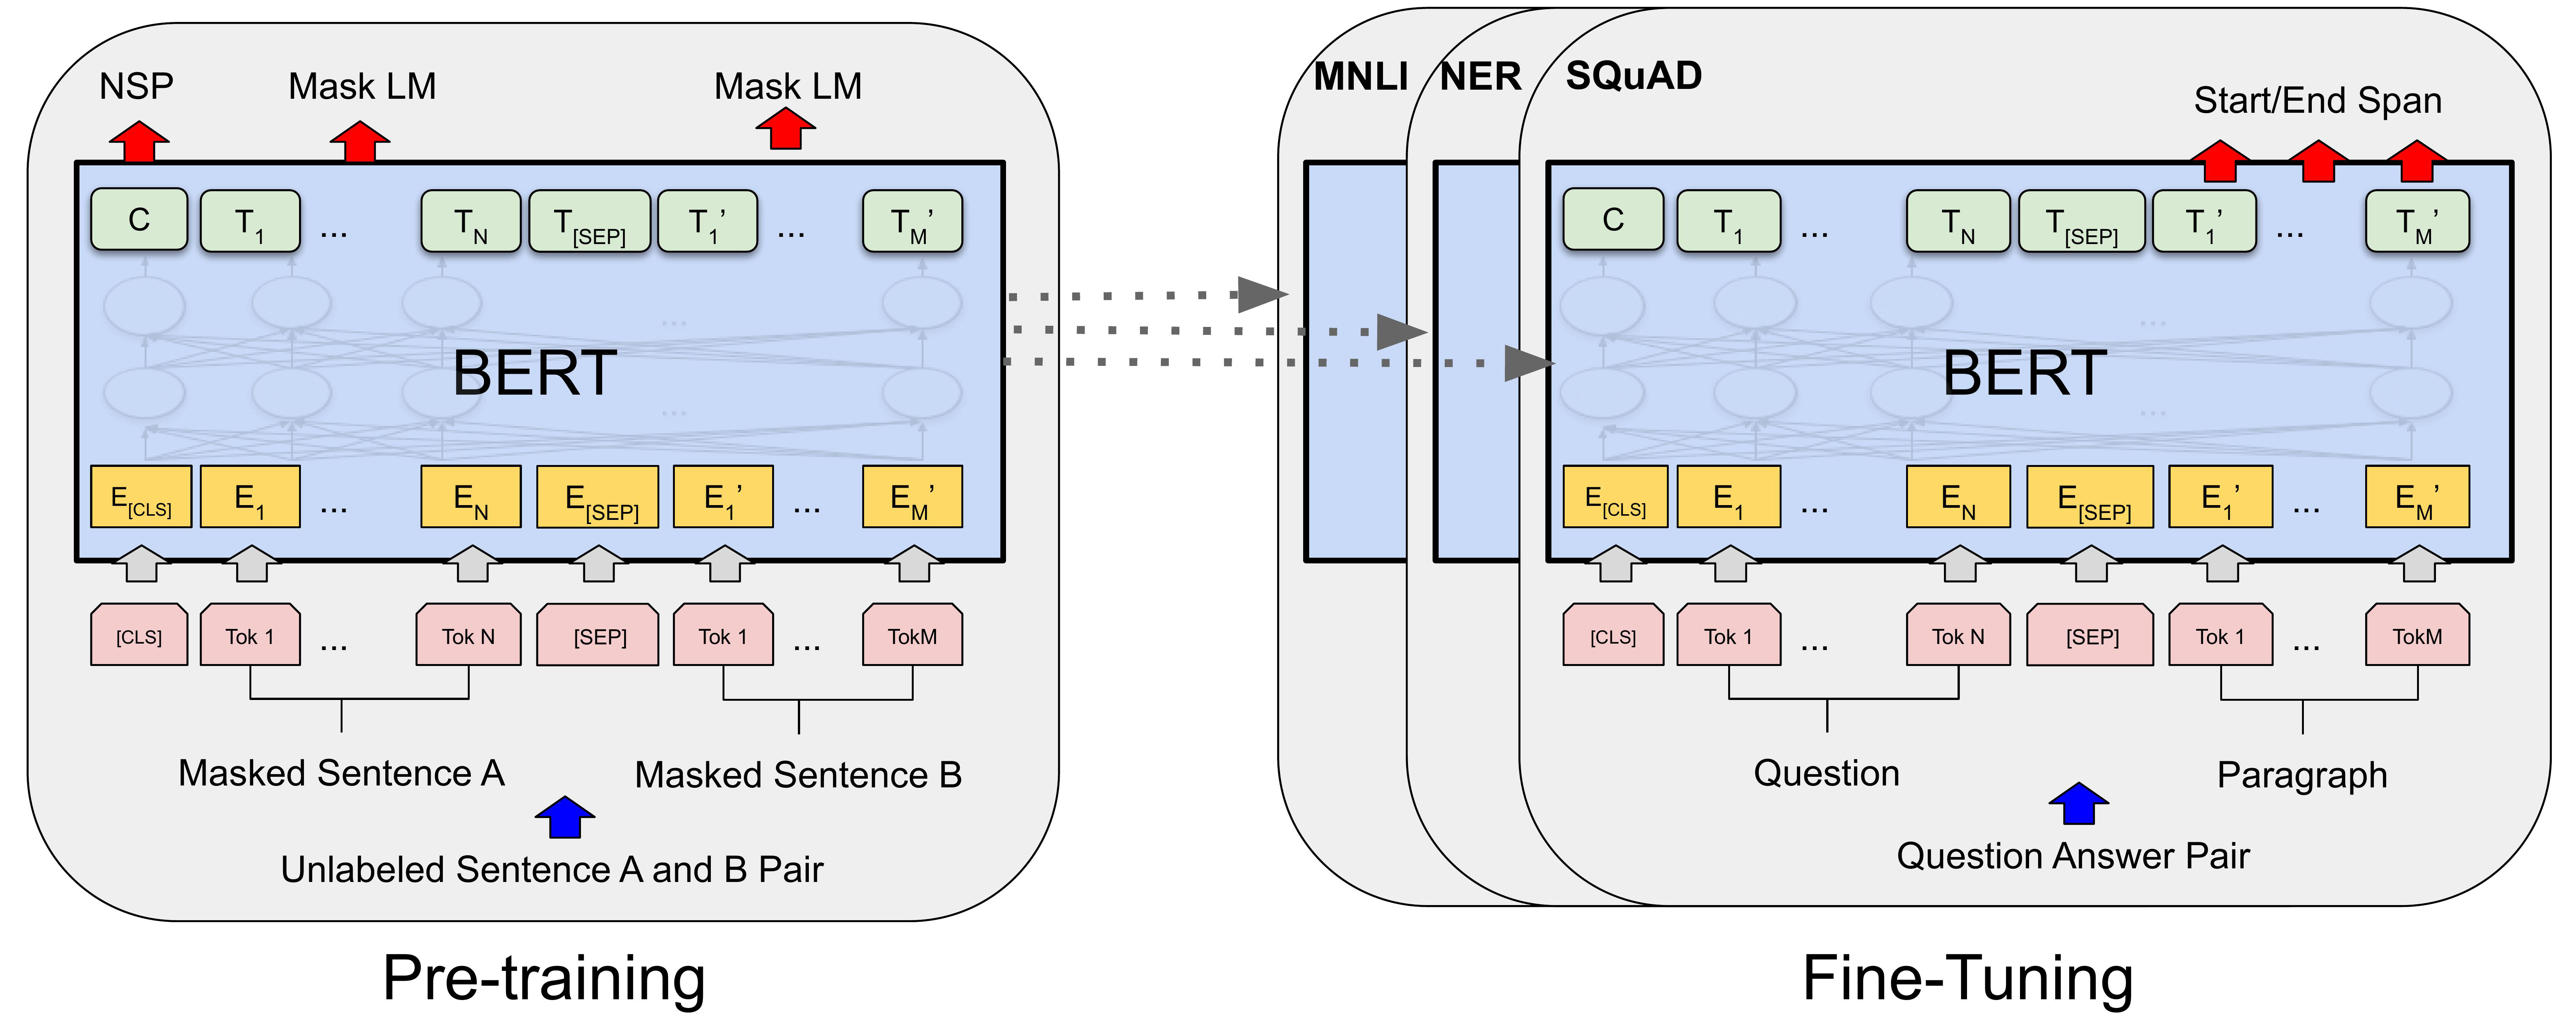
In part [1](https://charliezcr.github.io/sa_p1.html), I used TF-IDF to convert a sentence into a vector, sentences into a matrix. In this part, I will directly use BERT tokenizer to convert sentences into encodings, consisting of input IDs and attention masks. Input IDs are tokens for BERT converted from the words in a sentence. attention masks indicates how much attention each token need in a sentence. 

For example, in the sentence *There are two birds.* If "There" gets the most attention, we know that the birds are there, instead of here. If "two" gets the most attention, we know that there are more than 1 bird, less than 3 birds. If "birds", we know that the beings there are birds, not other things.

The attention mechanism in BERT makes this encoder efficent in sentiment analysis because it will notice that the words and phrases containing emotions, such as "like" and "don't like", need the most attention in movie reviews. Also, BERT tokenizer reads the sentences bidirectional, meaning both left-to-right and right-to-left, so that it also takes the position of a word in a sentence in to account.

When tokenizing the sentences, the maximum length will be set to 128. So the sentences with more than 126 tokens (the 2 other tokens are "cls" and "sep", meaning the start and the end of a sentence) will be truncated. The sentence with less than 126 with have zero paddings at the end.

In [13]:
from transformers import BertTokenizer
# load bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# setting the maximum length of encodings to 128, so that encodings will not be too long
encodings = tokenizer(reviews, truncation=True, padding='max_length', return_tensors='pt',
                      max_length=128)
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

Let us take a look at the first review and see how it is encoded by BERT tokenizer.

In [14]:
print(f'The original sentence: {reviews[0]}')
print(f'Input ID: {input_ids[0]}')
print(f'Attention mask: {attention_masks[0]}')

The original sentence: A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  
Input ID: tensor([  101,  1037,  2200,  1010,  2200,  1010,  2200,  4030,  1011,  3048,
         1010,  6614,  3238,  3185,  2055,  1037, 24305,  1010, 15013,  2402,
         2158,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,

# Dataset and Dataloader
After the sentences are encoded, the input IDs, attention masks and labels will be stored in the tensor form in TensorDataset and split into training and testing set. Then, Dataloaders wrap iterables over datasets, and support automatic batching, sampling, shuffling and multiprocess data loading.

batching means that the dataloader will send a batch of encodings into the model for mini-batch Stochastic Gradient Descent in the training process. In this study, I set the batch size to 16. Every time, the dataloader will shuffle all the data in the training set for a new batch.

In [18]:
from torch.utils.data import TensorDataset, random_split, DataLoader
# splitting traing and validation dataset
dataset = TensorDataset(input_ids, attention_masks, torch.tensor(labels))
train_size = int(df.shape[0] * 0.8)
val_size = df.shape[0] - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# load datasets into dataloaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(val_dataset, batch_size=16)

# Training
Epochs meaning how many times the training set will be sent to the model in the training process. For the training, I will set the number of epochs to 3. Usually the recommended number of epochs is 2-4. I will use ADAM as the optimizer for gradient descent.

In [20]:
from transformers import BertForSequenceClassification, AdamW, get_scheduler
from tqdm.auto import tqdm
# setting the model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2,  # The number of output labels--2 for binary classification.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)


# setting the epochs
num_epochs = 3
# setting for gradient descent
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.train()
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # send batches to device (cpu or gpu)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        outputs = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/150 [00:00<?, ?it/s]

## Evaluation

In [30]:
from sklearn.metrics import accuracy_score
y_pred = []
y_true = []
model.eval()
for batch in eval_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    # set gradient to zero at the start of every batch
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    y_pred.extend(predictions.tolist())
    y_true.extend(b_labels.tolist())
print(f'Accuracy: {accuracy_score(y_pred, y_true)}')

Accuracy: 0.905


We can see that the accuracy is higher than 90%, also better than the classic supervised training in part 1-3, proving that BERT is a more advanced model for sentiment analysis.